In [15]:
import sys
sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/attentionSNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs
    )

import resnet_2

from datetime import datetime
import glob
import random

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 1, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 1, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 1, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12          [32, 64, 1, 1, 1]               0
           Conv3d-13           [32, 8, 1, 1, 1]             512
             ReLU-14           [32, 8, 

In [17]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 # 1e-3 -> 1e-4 -> 5e-5 
Batch_size  = 32
num_epochs  = 5
num_workers = 4
IMAGE_HEIGHT = 256 # 512 originally
IMAGE_WIDTH  = 256 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = True
CHECKPOINT_NAME = "Att_Res_SNN_checkpoint_2_2025-04-22_02-29-59.pth.tar"
IMG_DIR      =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [18]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
        
    return running_loss/len(loader)

In [19]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        check_accuracy(val_loader, model, device=Device)
        
    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        val_acc, val_dice = check_accuracy(val_loader, model, device=Device)

        train_losses.append(train_loss)
        val_accs.append(val_acc.cpu().item())
        val_dice_scores.append(val_dice.cpu().item())

        scheduler.step(val_dice)
        print(f"Epoch {epoch}: LR = {optimizer.param_groups[0]['lr']}")

        checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        }
        checkpoint_filename = save_checkpoint(checkpoint, is_best=len(val_dice_scores) == 1 or val_dice_scores[-1] > max(val_dice_scores[:-1]))

        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=False,
            )
        else:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores, 
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=True,
            )

✅ Loaded checkpoint: Att_Res_SNN_checkpoint_2_2025-04-22_02-29-59.pth.tar
Got 25353389/29360128 with acc  86.35
Dice score: 0.19568772614002228


100%|███████████████████████████████████████████████████████████████████████| 82/82 [02:32<00:00,  1.87s/it, loss=0.58]


Got 26164862/29360128 with acc  89.12
Dice score: 0.21362760663032532
Epoch 0: LR = 0.001
✅ Checkpoint saved: Att_Res_SNN_checkpoint_3_2025-04-22_03-49-45.pth.tar


100%|██████████████████████████████████████████████████████████████████████| 82/82 [02:31<00:00,  1.84s/it, loss=0.552]


Got 26623682/29360128 with acc  90.68
Dice score: 0.2387864887714386
Epoch 1: LR = 0.001
✅ Checkpoint saved: Att_Res_SNN_checkpoint_4_2025-04-22_03-52-59.pth.tar


100%|███████████████████████████████████████████████████████████████████████| 82/82 [02:30<00:00,  1.84s/it, loss=0.52]


Got 28007793/29360128 with acc  95.39
Dice score: 0.2755551338195801
Epoch 2: LR = 0.001
✅ Checkpoint saved: Att_Res_SNN_checkpoint_5_2025-04-22_03-56-14.pth.tar


100%|███████████████████████████████████████████████████████████████████████| 82/82 [02:31<00:00,  1.85s/it, loss=0.49]


Got 27892094/29360128 with acc  95.00
Dice score: 0.32673379778862
Epoch 3: LR = 0.001
✅ Checkpoint saved: Att_Res_SNN_checkpoint_6_2025-04-22_03-59-29.pth.tar


100%|██████████████████████████████████████████████████████████████████████| 82/82 [02:32<00:00,  1.86s/it, loss=0.467]


Got 28154387/29360128 with acc  95.89
Dice score: 0.3696717321872711
Epoch 4: LR = 0.001
✅ Checkpoint saved: Att_Res_SNN_checkpoint_7_2025-04-22_04-02-46.pth.tar


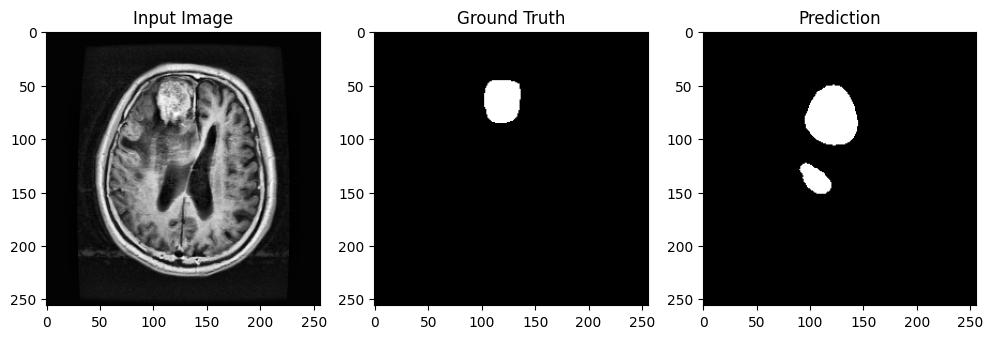

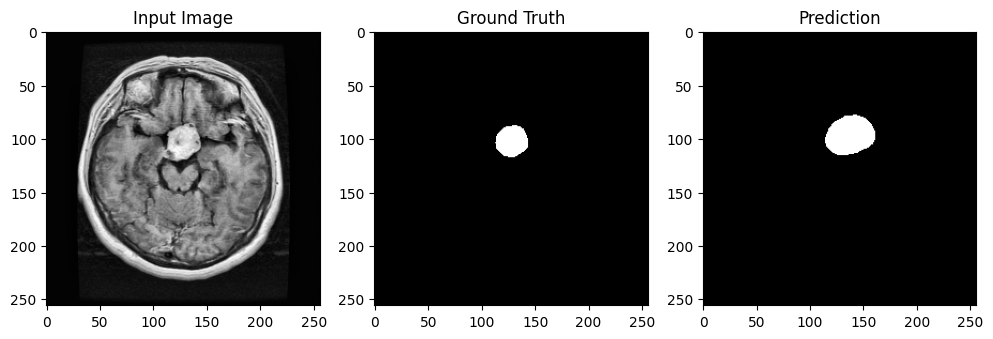

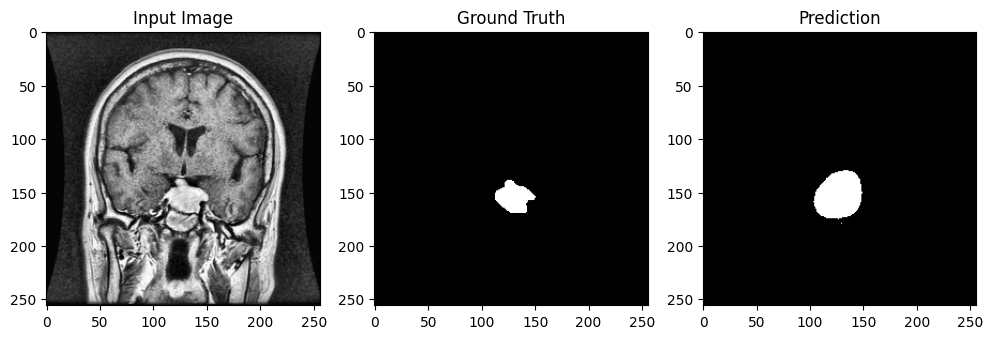

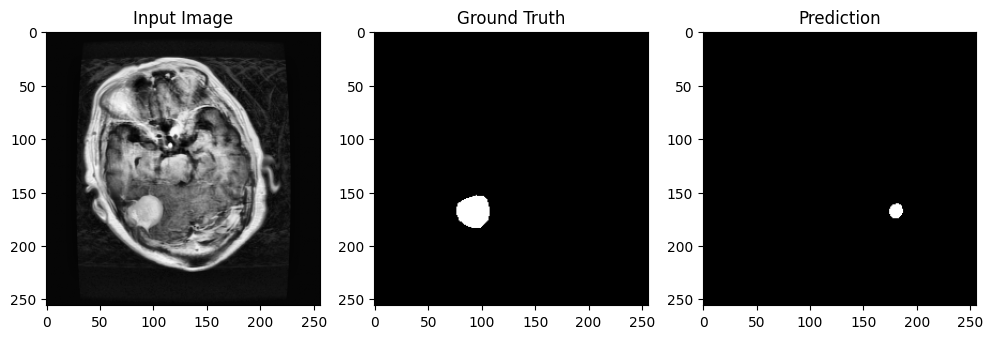

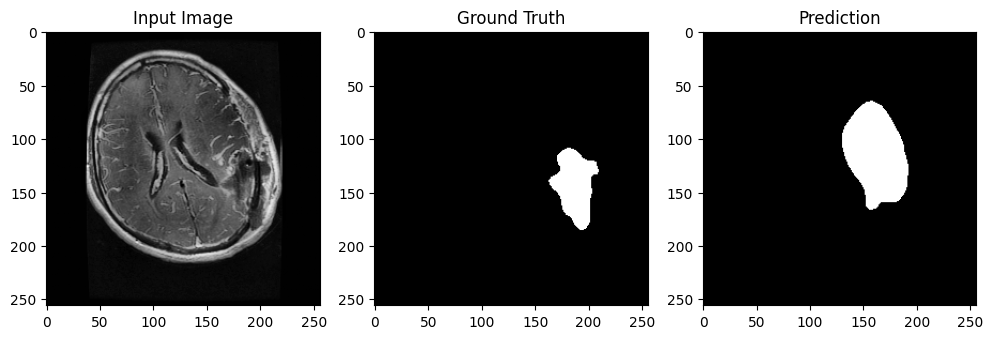

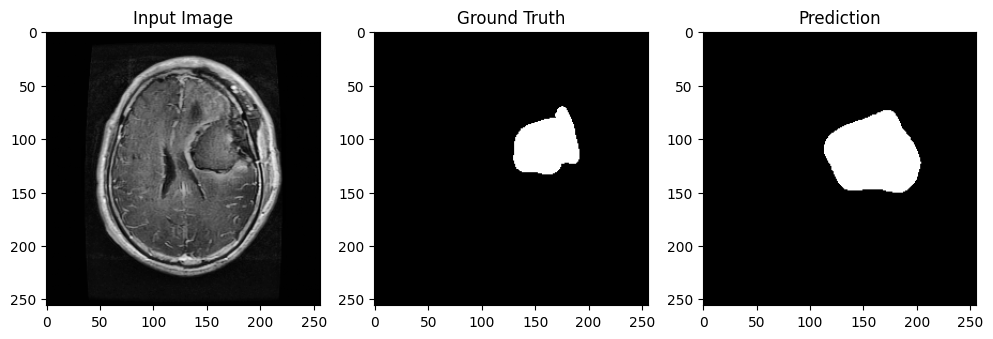

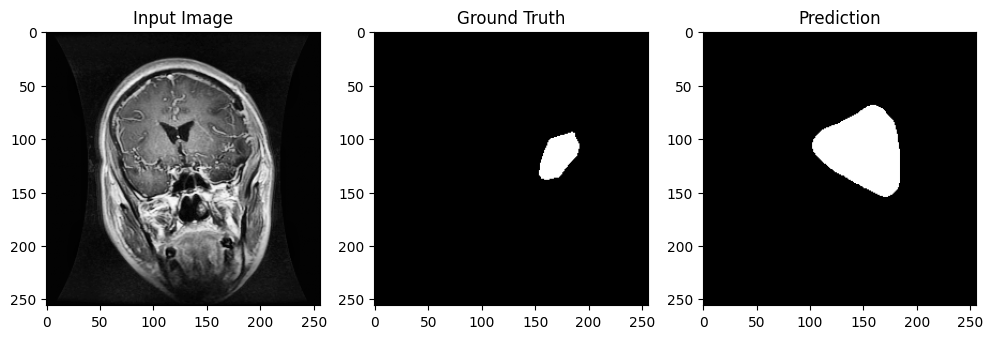

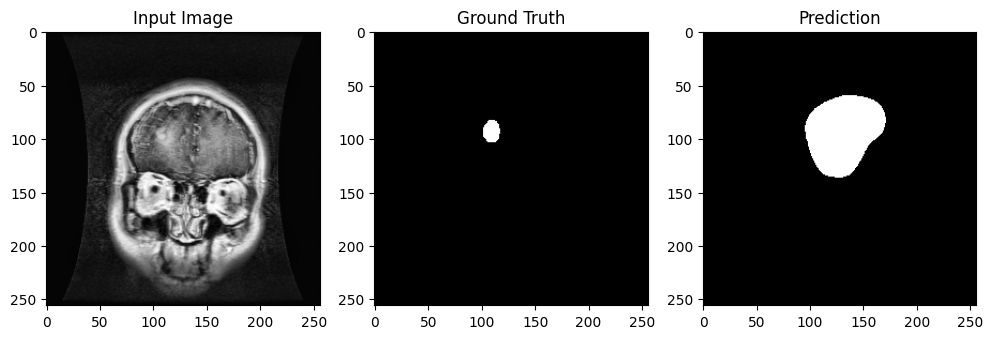

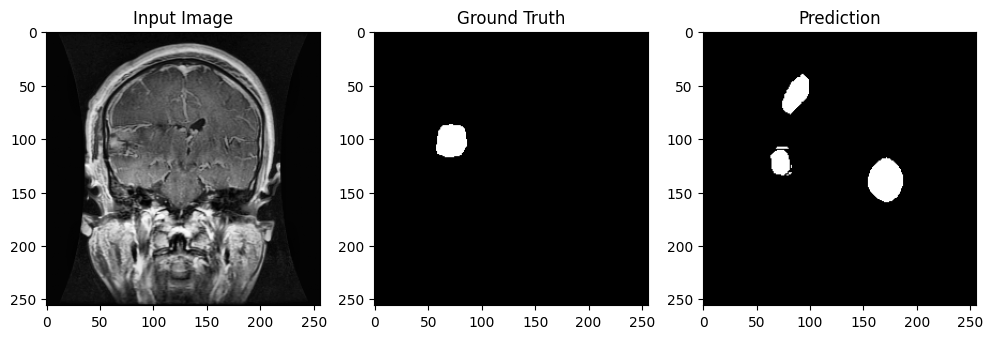

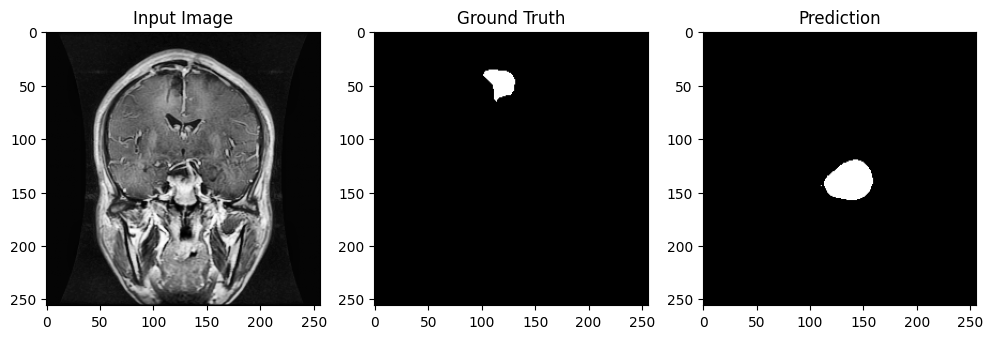

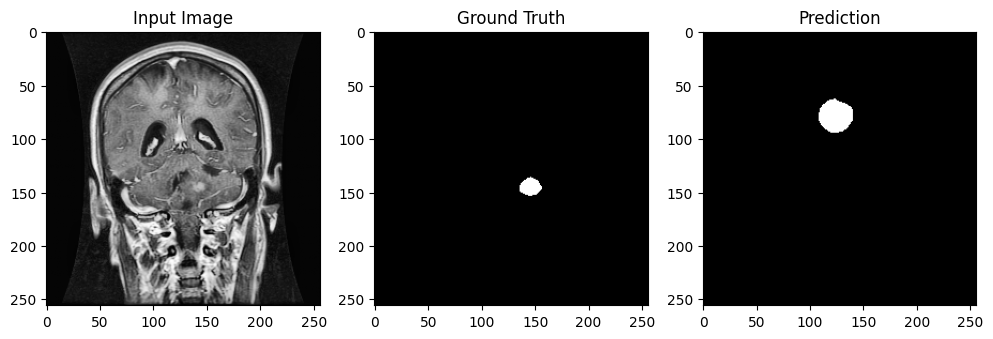

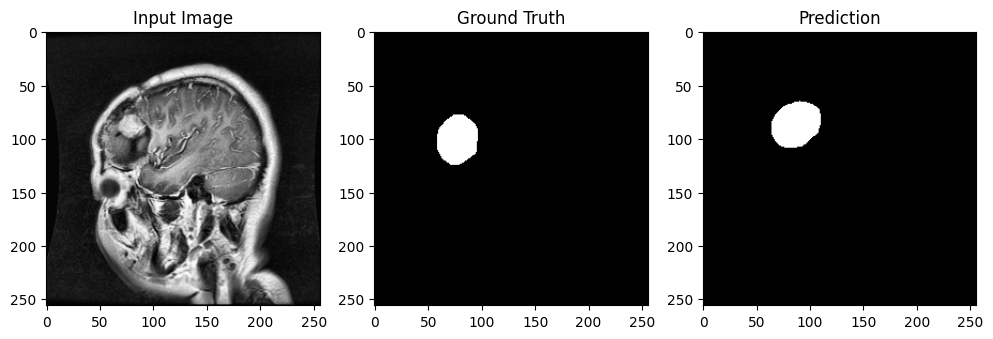

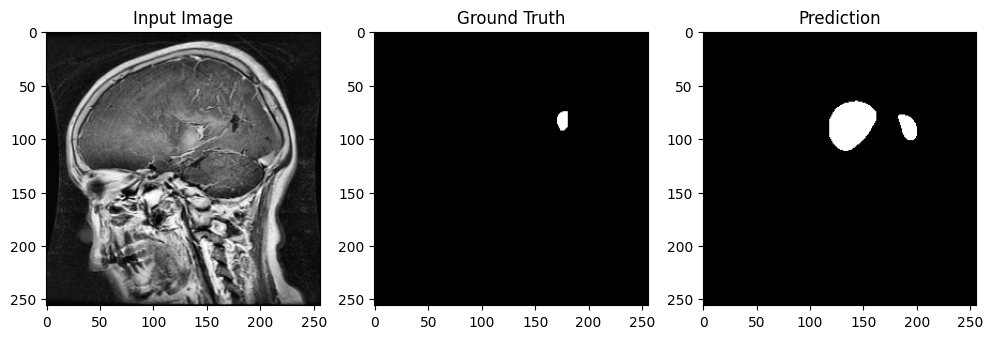

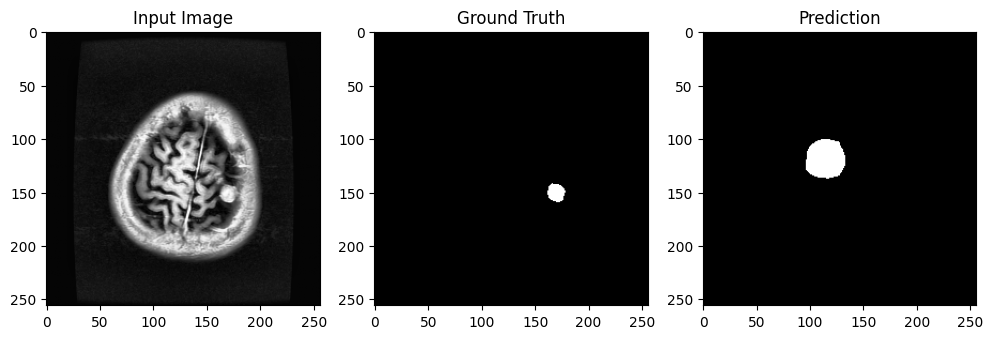

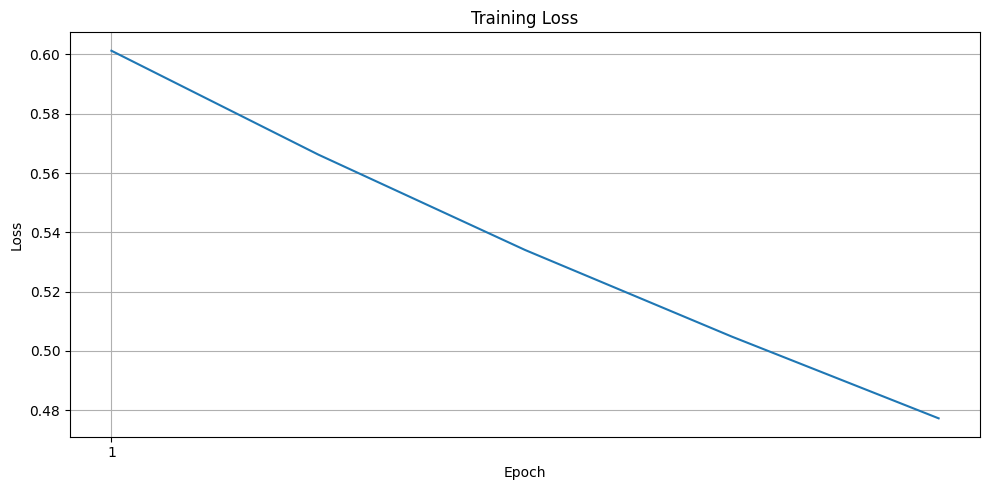

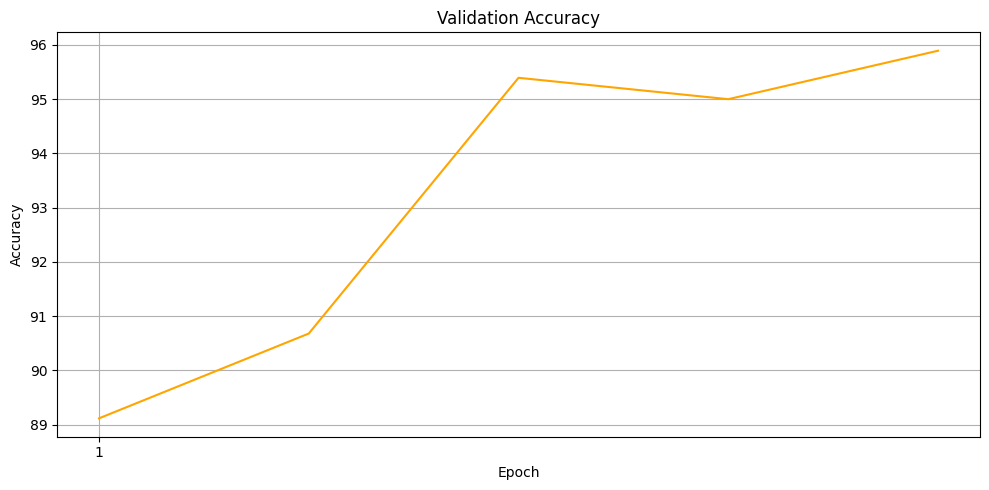

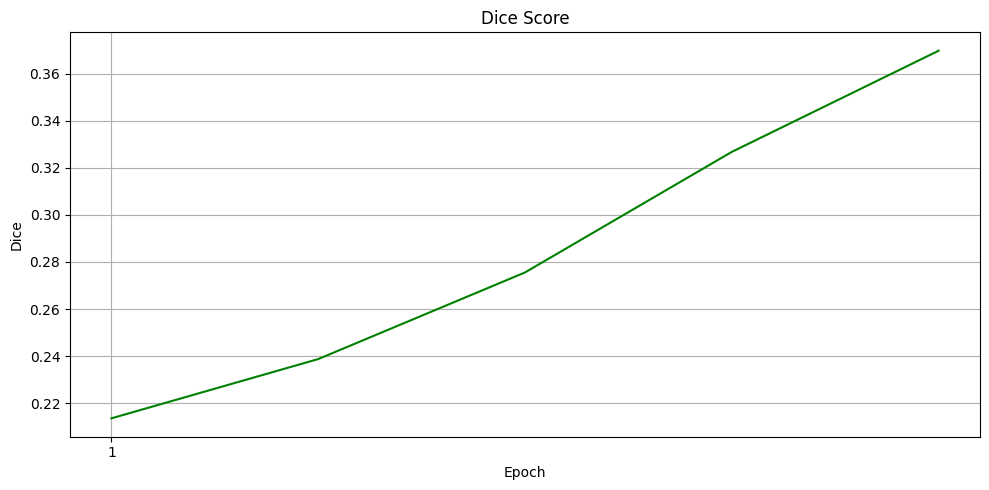

In [20]:
if __name__ == "__main__": 
    main()

## Grad-CAM

In [37]:
def load_and_preprocess_image(image_path):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image = Image.open(image_path).convert("L")
    image_rgb = Image.open(image_path).convert("RGB")
    processed = transform(image=np.array(image))
    input_tensor = processed['image'].unsqueeze(0)
    vis_image = np.array(image_rgb.resize((256, 256))) / 255.0
    return input_tensor, vis_image

def reshape_transform_csa(tensor):
    # If tensor shape is [B, C, T, H, W], convert to [B, C*T, H, W]
    if tensor.ndim == 5:
        B, C, T, H, W = tensor.size()
        return tensor.permute(0, 2, 1, 3, 4).reshape(B, T * C, H, W)
    elif tensor.ndim == 4:
        return tensor  # Already [B, C, H, W]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
    
def reshape_transform_spiking(tensor):
    """Special reshape for spiking networks with attention"""
    if tensor.ndim == 5:  # [T,B,C,H,W]
        # For attention weights
        if tensor.shape[2] == 1:  # Attention mask case
            return tensor.mean(dim=0).mean(dim=1)  # [B,H,W]
        
        # For regular feature maps
        B, C, T, H, W = tensor.permute(1,2,0,3,4).shape
        return tensor.permute(1,0,2,3,4).reshape(B, T*C, H, W)
    
    elif tensor.ndim == 4:  # [B,C,H,W]
        return tensor
    
    raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

In [38]:
def generate_gradcam_grid_multi_layers(
    model,
    image_paths,
    mask_paths,
    target_layers_dict,
    device="cuda",
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
    ):
    os.makedirs(save_folder, exist_ok=True)
    model.to(device).eval()

    selected = random.sample(list(zip(image_paths, mask_paths)), grid_rows * grid_cols)

    for layer_name, target_layer in target_layers_dict.items():

        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        layer_folder_name = f"{layer_name.replace('.', '_').replace('[', '_').replace(']', '')}_{timestamp}"
        layer_folder = os.path.join(save_folder, layer_folder_name)
        os.makedirs(layer_folder, exist_ok=True)

        cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_csa)
        # cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_spiking)

        fig_cam, axes_cam = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_mask, axes_mask = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_idx = 0

        for img_path, mask_path in selected:
            input_tensor, vis_image = load_and_preprocess_image(img_path)
            input_tensor = input_tensor.to(device)

            mask_tensor, _ = load_and_preprocess_image(mask_path)
            input_mask_tensor = mask_tensor.squeeze(0).cpu().numpy()

            targets = [SemanticSegmentationTarget(0, input_mask_tensor)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            binary_seg_mask = (grayscale_cam > 0.8).astype(np.uint8)

            # Save CAM image
            cam_image = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)
            cam_save_path = os.path.join(layer_folder, f"cam_{os.path.basename(img_path)}")
            plt.imsave(cam_save_path, cam_image)

            # Save binary segmentation mask
            bin_mask_path = os.path.join(layer_folder, f"mask_{os.path.basename(img_path)}")
            plt.imsave(bin_mask_path, binary_seg_mask, cmap='gray')

            row = fig_idx // grid_cols
            col = fig_idx % grid_cols

            if row < grid_rows:
                axes_cam[row, col].imshow(cam_image)
                axes_cam[row, col].axis("off")
                axes_cam[row, col].set_title(f"{os.path.basename(img_path)}")

                axes_mask[row, col].imshow(binary_seg_mask, cmap='gray')
                axes_mask[row, col].axis("off")
                axes_mask[row, col].set_title(f"{os.path.basename(img_path)}")

                fig_idx += 1

        # Save full CAM grid
        grid_cam_path = os.path.join(layer_folder, f"grid_cam_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_cam.savefig(grid_cam_path)
        plt.close(fig_cam)

        # Save full binary segmentation mask grid
        grid_mask_path = os.path.join(layer_folder, f"grid_mask_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_mask.savefig(grid_mask_path)
        plt.close(fig_mask)

        print(f"✅ Saved {grid_cam_path}")
        print(f"✅ Saved {grid_mask_path}")

In [42]:
model = resnet_2.resnet34().to(device)
# checkpoint = torch.load("E:/Code/Attention-SNN/Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_40_2025-04-14_08-50-42.pth.tar", map_location="cuda")
checkpoint = torch.load("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_7_2025-04-22_04-02-46.pth.tar", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])

image_paths = sorted(glob.glob(os.path.join(VAL_IMG_DIR, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(VAL_MASK_DIR, "*.png")))

# target_layers = {
#     "conv4_attention_sa": model.conv4_x[-1].residual_function[-1].attention.sa.conv,
#     # "conv4_residual":     model.conv4_x[-1].residual_function[-1],
#     # "conv4":              model.conv4_x[-1],

#     "conv5_attention_sa": model.conv5_x[-1].residual_function[-1].attention.sa.conv,
#     # "conv5_residual":     model.conv5_x[-1].residual_function[-1],
#     # "conv5":              model.conv5_x[-1],

#     # "segmentation_layer":    model.segmentation_layer,
# }

target_layers = {
    "segmentation_layer_layers[0]": model.segmentation_layer.layers[0],
    "segmentation_layer_layers[1]": model.segmentation_layer.layers[1],
    "segmentation_layer_layers[2]": model.segmentation_layer.layers[2],
    "segmentation_layer_layers[3]": model.segmentation_layer.layers[3],
    "segmentation_layer_layers[4]": model.segmentation_layer.layers[4],
}

generate_gradcam_grid_multi_layers(
    model=model,
    image_paths=image_paths,
    mask_paths=mask_paths,
    target_layers_dict=target_layers,
    device=device,
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
)

✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_0_20250422-061210\grid_cam_segmentation_layer_layers[0]_20250422-061210.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_0_20250422-061210\grid_mask_segmentation_layer_layers[0]_20250422-061210.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_1_20250422-061219\grid_cam_segmentation_layer_layers[1]_20250422-061219.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_1_20250422-061219\grid_mask_segmentation_layer_layers[1]_20250422-061219.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_2_20250422-061228\grid_cam_segmentation_layer_layers[2]_20250422-061228.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_2_20250422-061228\grid_mask_segmentation_layer_layers[2]_20250422-061228.png
✅ Saved Att_Res_SNN_gradcam_results\segmentation_layer_layers_3_20250422-061238\grid_cam_segmentation_layer_layers[3]_20250422-061238.png
✅ Saved Att_Res_SNN_gradcam_res